In [31]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from multivariate_laplace import multivariate_laplace
import pandas as pd
import pickle
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


### Часть 1. Сравнение EM и Kmeans алгоритма для трех Гаусовских смесей.

Создадим класс для кластеризации:

In [32]:
class EM_algo:
 
    def __init__(self, X, mu_init, sigma_init, pi_init, N_mixtures):
        """X - данные
        mu - среднее значение гауссианов,
        sigma - матрицы ковариации,
        pi - коэффициенты смеси,
        N_mixtures - число смесей всего,
        N, D - число точек и размерность данных,
        EZ - метки классов"""


        self.X = np.vstack(X) 
        self.mu = mu_init      
        self.sigma = sigma_init       
        self.pi = pi_init      
        self.N_mixtures = N_mixtures     
        self.N, self.D = np.shape(self.X)  
        self.EZ = np.zeros([self.N, N_mixtures]) 

    def expectation(self):

        """ 'Е' часть алгоритма. Нахождение предполагаемых
          меток каждой из точек
        """

        for n in range(self.N):
            den = 0.0
            for k in range(self.N_mixtures):
                den += self.pi[k] * multivariate_normal.pdf(self.X[n],
                                                            self.mu[k],
                                                            self.sigma[k])
            for k in range(self.N_mixtures):
                num = self.pi[k] * multivariate_normal.pdf(self.X[n],
                                                           self.mu[k],
                                                           self.sigma[k])
                self.EZ[n, k] = num/den

    def maximization(self, X, L):
        """'M' часть алгоритма. Находит максимизирущие параметры для распределений.
        Здесь L - метки"""


        for k in range(self.N_mixtures):
            Nk = np.sum(L[:, k])
            self.pi[k] = Nk / self.N

            self.mu[k] = 0.0
            for n in range(self.N):
                self.mu[k] += 1/Nk * L[n, k]*X[n]
            self.sigma[k] = np.zeros([self.D, self.D])
            for n in range(self.N):
                self.sigma[k] += 1/Nk * L[n, k] * (np.vstack(X[n] - self.mu[k]) *
                                               (X[n]-self.mu[k]))

    def train(self, Ni):
        """ 
        Нахождение гауссианов с помощью EM алгоритма
        """
        print('Training...')
        for i in range(Ni):
            print('Iteration', i)
            self.expectation()
            self.maximization(self.X, self.EZ)

Скачаем данные для кластеризации обычных Гауссовых распределений:

In [33]:
dataset = torch.load('EM_test_data.pt')
dataset = dataset.T
dataset

tensor([[-1.2841, -1.2712,  0.8043,  ..., -3.0772, -4.2756, -1.7122],
        [-1.4371, -0.2569,  0.3009,  ..., -0.4846, -1.0018,  1.3275]])

Давайте посмотрим на данные прежде, чем кластеризировать их:

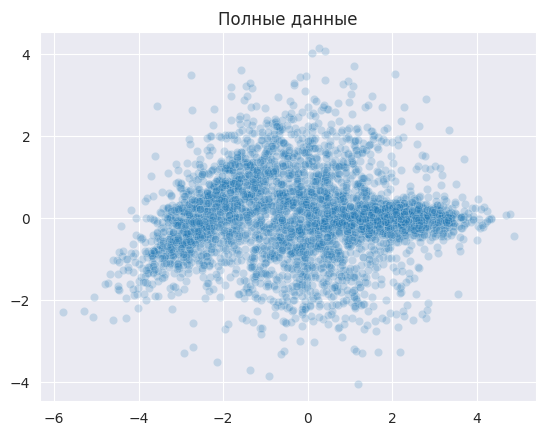

In [34]:
with sns.axes_style('darkgrid'):
    ax = sns.scatterplot(x = dataset[0], y=dataset[1], alpha=0.2)
    ax.set(title='Полные данные', ylabel = None, xlabel = None)
    fig = ax.get_figure()
    fig.savefig('presentation/images/data.png')

По данным явно прослеживаются два более плотных распределения (слева немного подиагонали и справо горизонтально), при этом логично предположить, что оставшиеся точки - еще одно, менее плотное распределение.
Итого 3 нормальных распределения, что согласуется с постоновкой задачи.

Теперь кластеризируем данные с помощью ЕМ алгоритма и посмотрим на результаты

In [85]:
dataset = dataset.T
type(dataset)

torch.Tensor

In [86]:
mu = []
C = []
for i in range(3):
    mu.append(np.random.randn(2))
    C.append(np.eye(2))
pi = np.array([1/3, 1/3, 1/3])
gmm = EM_algo(X=dataset, mu_init=mu, sigma_init=C, pi_init=pi, N_mixtures=3)
gmm.train(Ni=100)

Training...
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 

In [87]:
for i in range(3):
    print(gmm.sigma[i])

[[0.76349318 0.5671512 ]
 [0.5671512  0.74198304]]
[[ 0.77111451 -0.00142119]
 [-0.00142119  0.04754603]]
[[ 1.56044525 -0.07429289]
 [-0.07429289  1.60501123]]


In [88]:
EZ = np.array(gmm.EZ)
chosen_indices = np.array([np.random.choice(range(EZ.shape[1]), p=EZ[i]) for i in range(EZ.shape[0])])

In [89]:
first = (dataset[chosen_indices == 0]).T
second = (dataset[chosen_indices == 1]).T
third = (dataset[chosen_indices == 2]).T

In [90]:
dataset = dataset.T

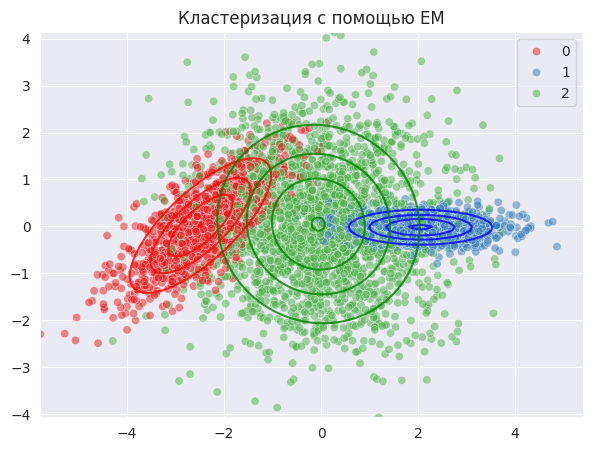

In [91]:
r1 = np.linspace(np.min(gmm.X[:, 0]), np.max(gmm.X[:, 1]), 100)
r2 = np.linspace(np.min(gmm.X[:, 1]), np.max(gmm.X[:, 1]), 100)
x_r1, x_r2 = np.meshgrid(r1, r2)
pos = np.empty(x_r1.shape + (2, ))
pos[:, :, 0] = x_r1
pos[:, :, 1] = x_r2

fig = plt.figure(figsize=(7, 5))

with sns.axes_style("darkgrid"):
    ax = fig.add_subplot()
    sns.scatterplot(x = dataset[0], y=dataset[1], alpha=0.5, hue=chosen_indices, palette="Set1", ax=ax)
    # sns.kdeplot(x=first[0], y=first[1], levels=1, alpha = 0.5, color='red', ax=ax)
    # sns.kdeplot(x=second[0], y=second[1], levels=1, alpha = 0.5, color='blue', ax=ax)
    # sns.kdeplot(x=third[0], y=third[1], levels=1, alpha = 0.5, color='green', ax=ax)
    colors = ['red', 'blue', 'green']
    for k in range(gmm.N_mixtures):
        p = multivariate_normal(gmm.mu[k], gmm.sigma[k])
        plt.contour(x_r1, x_r2, p.pdf(pos), levels = 4, colors = colors[k], alpha = 0.8)
    ax.set(title='Кластеризация с помощью EM', ylabel = None, xlabel = None)
    
    fig = ax.get_figure()
    fig.savefig('presentation/images/em_claster.png')

Теперь проведем кластеризацию при помощи метода Kmeans.

In [92]:
dataset = dataset.T

In [93]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=1000).fit(dataset)
labels = kmeans.labels_

Теперь визуализируем Kmeans

In [94]:
first_kmeans = (dataset[labels == 0]).T
second_kmeans = (dataset[labels == 1]).T
third_kmeans = (dataset[labels == 2]).T

In [95]:
dataset = dataset.T

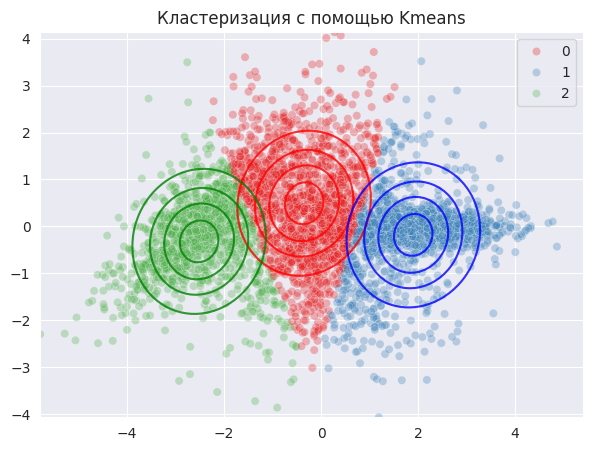

In [96]:
r1 = np.linspace(np.min(gmm.X[:, 0]), np.max(gmm.X[:, 1]), 100)
r2 = np.linspace(np.min(gmm.X[:, 1]), np.max(gmm.X[:, 1]), 100)
x_r1, x_r2 = np.meshgrid(r1, r2)
pos = np.empty(x_r1.shape + (2, ))
pos[:, :, 0] = x_r1
pos[:, :, 1] = x_r2

fig = plt.figure(figsize=(7, 5))

with sns.axes_style("darkgrid"):
    ax = fig.add_subplot()
    sns.scatterplot(x = dataset[0], y=dataset[1], alpha=0.3, hue=labels, palette="Set1")
    # sns.kdeplot(x=first_kmeans[0], y=first_kmeans[1], levels=1, alpha = 0.5, color='red')
    # sns.kdeplot(x=second_kmeans[0], y=second_kmeans[1], levels=1, alpha = 0.5, color='blue')
    # sns.kdeplot(x=third_kmeans[0], y=third_kmeans[1], levels=1, alpha = 0.5, color='green')

    colors = ['red', 'blue', 'green']
    all_kmeans = [first_kmeans, second_kmeans, third_kmeans]
    for k in range(3):
        p = multivariate_normal(all_kmeans[k].mean(axis=1), all_kmeans[i].cov())
        plt.contour(x_r1, x_r2, p.pdf(pos), levels = 4, colors = colors[k], alpha = 0.8)
    ax.set(title='Кластеризация с помощью Kmeans', ylabel = None, xlabel = None)
    
    fig = ax.get_figure()
    fig.savefig('presentation/images/Kmeans_claster.png')

### Часть 2. EM алгоритм для 2х нормальных и одного Лапласовского распределения.

Скачаем данные:

In [97]:
dataset = torch.load('EM_test_data_2 .pt')
dataset = dataset.T
dataset

tensor([[-1.8538e+00,  2.8262e-01, -9.1435e-01,  ..., -2.7002e+00,
         -2.3252e+00, -2.9594e+00],
        [-8.8051e-03, -1.6856e-01, -2.8593e+00,  ..., -2.4440e-03,
          1.7600e-01, -3.8360e-01]])

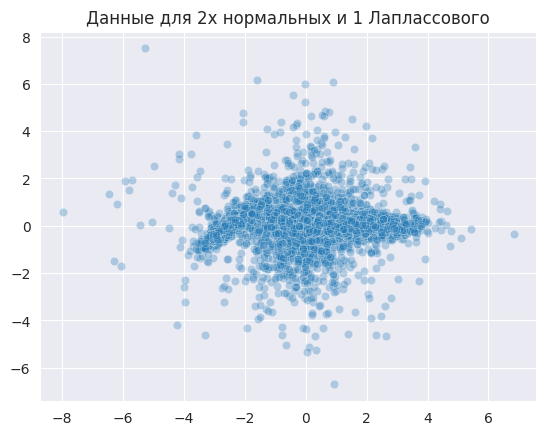

In [123]:
with sns.axes_style('darkgrid'):
    fig = sns.scatterplot(x = dataset[0], y=dataset[1], alpha=0.3)
    fig.set(title = 'Данные для 2х нормальных и 1 Лаплассового', ylabel = None, xlabel = None)
    fig = fig.get_figure()
    fig.savefig('presentation/images/data_2.png')

In [99]:
class EM_algo_gaus_laplace:
    def __init__(self, X, mu_init, sigma_init, pi_init):
        """ 
        ЕМ алгоритм для двух нормальных и одного лаплассового распределения
        X - данные
        mu_first, mu_second - средние значения гауссианов
        mu_third - среднее значение лаплассиана
        sigma - матрицы ковариации гауссиана
        b - матрица разнообразия лаплассиана
        EZ - метки классов
        """
        
        self.X = np.vstack(X)
        self.mu = mu_init
        self.sigma = sigma_init
        self.pi = pi_init 
        self.N, self.D = np.shape(self.X)
        self.EZ = np.zeros([self.N, 3])

    
    def expectation(self):
        """ 'Е' часть алгоритма. Нахождение предполагаемых
          меток каждой из точек
        """
        for n in range(self.N):
            den = 0.0
            for k in range(2):
                den += self.pi[k] * multivariate_normal.pdf(self.X[n], self.mu[k], self.sigma[k])
            den += self.pi[2] * multivariate_laplace.pdf(self.X[n], self.mu[2], self.sigma[2])

            for k in range(2):
                num = self.pi[k] * multivariate_normal.pdf(self.X[n], self.mu[k], self.sigma[k])
                self.EZ[n, k] = num/den
            
            num = self.pi[2] * multivariate_laplace.pdf(self.X[n], self.mu[2], self.sigma[2])

            self.EZ[n, 2] = num/den
            



    def maximization(self, X):
        for k in range(3):
            Nk = np.sum(self.EZ[:, k])
            self.pi[k] = Nk / self.N

            self.mu[k] = 0.0
            for n in range(self.N):
                self.mu[k] += 1/Nk * self.EZ[n, k]*X[n]
            self.sigma[k] = np.zeros([self.D, self.D])
            for n in range(self.N):
                self.sigma[k] += 1/Nk * self.EZ[n, k] * (np.vstack(X[n] - self.mu[k]) *
                                               (X[n]-self.mu[k]))
     
    def train(self, Ni):
        """ 
        Нахождение гауссианов с помощью EM алгоритма
        """
        print('Training...')
        for i in range(Ni):
            print('Iteration', i)
            self.expectation()
            self.maximization(self.X)


In [100]:
dataset = dataset.T
type(dataset)

torch.Tensor

In [102]:
mu = []
C = []
for i in range(3):
    mu.append(np.random.randn(2))
    C.append(np.eye(2))
pi = np.array([1/3, 1/3, 1/3])
gmm = EM_algo_gaus_laplace(X=dataset, mu_init=mu, sigma_init=C, pi_init=pi)
gmm.train(Ni=100)


Training...
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 

In [103]:
EZ = np.array(gmm.EZ)
chosen_indices = np.array([np.random.choice(range(EZ.shape[1]), p=EZ[i]) for i in range(EZ.shape[0])])

In [104]:
first = (dataset[chosen_indices == 0]).T
second = (dataset[chosen_indices == 1]).T
third = (dataset[chosen_indices == 2]).T

In [105]:
dataset = dataset.T

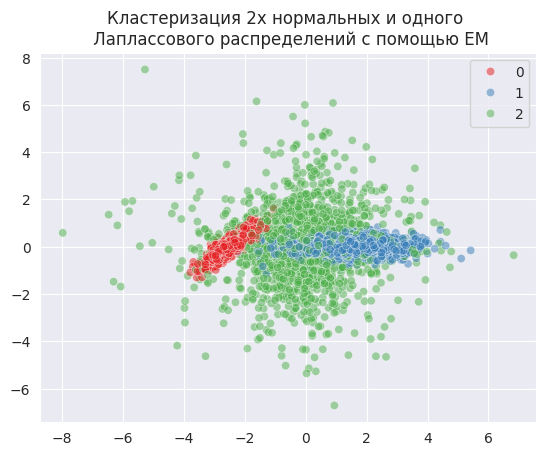

In [119]:
with sns.axes_style("darkgrid"):
    ax =sns.scatterplot(x = dataset[0], y=dataset[1], alpha=0.5, hue=chosen_indices, palette="Set1")
    ax.set_title('Кластеризация 2х нормальных и одного \n Лаплассового распределений с помощью EM')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    fig = ax.get_figure()
    fig.savefig('presentation/images/em_laplace_claster.png')